In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import reedsolo as rs
from reedsolo import ReedSolomonError

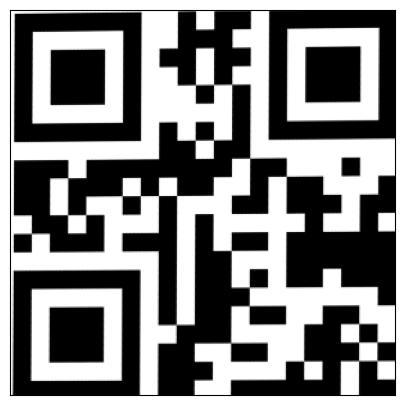

In [2]:
img6 = cv2.imread("TC-6.png", cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img6, cmap='gray');

(21, 21)


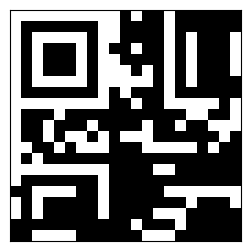

In [3]:
img6 = cv2.imread("TC-6.png", cv2.IMREAD_GRAYSCALE)

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img6):
    if (row != 255).any():
        start_row = row_index
        break

for row_index, row in enumerate(img6[::-1]):
    if (row != 255).any():
        end_row = img6.shape[0] - row_index
        break

for col_index, col in enumerate(cv2.transpose(img6)):
    if (col != 255).any():
        start_col = col_index
        break

for col_index, col in enumerate(cv2.transpose(img6)[::-1]):
    if (col != 255).any():
        end_col = img6.shape[1] - col_index
        break

img_no_quiet_zone = img6[start_row:end_row, start_col:end_col]

img_21x21_grid = cv2.resize(img_no_quiet_zone, (21, 21), interpolation=cv2.INTER_NEAREST) // 255

fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img_21x21_grid, cmap='gray');
print(img_21x21_grid.shape)

In [4]:
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [5]:
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [6]:
img_21x21_grid_inv = 1 - img_21x21_grid
ecl = img_21x21_grid_inv[8, 0:2]
mask = img_21x21_grid_inv[8, 2:5]
enc_bits = apply_mask_general(21-1, 21-1, img_21x21_grid_inv, mask, UP4)
len_bits = apply_mask_general(21-3, 21-1, img_21x21_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

ECL = [0 0]
MASK = [0 0 0]
ENC = [1, 1, 1, 1]
LEN = [0, 0, 0, 1, 0, 0, 0, 1] = 17 data symbols, each consisting of 8 bits


In [7]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [8]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)

byte_index = 0
for _ in range(len_int):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
bit_string = ''.join([str(bit) for bit in bits])
print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
byte_index += 1

for _ in range(25 - len_int - 1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

11110010 (=242) = ò
00110011 (=051) = 3
01100101 (=101) = e
01100100 (=100) = d
01011010 (=090) = Z
01010101 (=085) = U
10111111 (=191) = ¿
11110111 (=247) = ÷
11111100 (=252) = ü
01011111 (=095) = _
11001100 (=204) = Ì
00010101 (=021) = 
01011010 (=090) = Z
11010001 (=209) = Ñ
11010001 (=209) = Ñ
01010110 (=086) = V
11011100 (=220) = Ü
0110 (=END) -- the NULL TERMINATOR, followed by padding and/or ECC
01100100 (=100) = d
11100110 (=230) = æ
11001110 (=206) = Î
11011001 (=217) = Ù
11110101 (=245) = õ
00011110 (=030) = 
11111111 (=255) = ÿ
